# COV-19 Case Prediction


* 313个地方的cov-19　预测

This notebook aims to create models to predict COV-19 cases in 313 different areas of the world, using GluonTS models.

The data set is downloaded from Kaggle(https://www.kaggle.com/c/covid19-global-forecasting-week-5), you can download them and put all the csv files under a folder called \"covid19-global-forecasting-week-4\" in the same directory of this notebook.

**NOTE: this notebook is for illustration purposes only, it has not been reviewed by epidemiological experts, and we do not claim that accurate epidemiological predictions can be made with the code that follows.**

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
prediction_length = 20

## Load data and preprocessing
We first load the data from files. Since the original data doesn't meet the requirements of GluonTS models, we need to do data preprocessing and generate new dataframe where each row represents a time series for a certain place.

In [3]:
file_path = "/home/chenkai/Documents/git_projects/gluon-ts/examples/data/covid19-global-forecasting-week-5"

total = pd.read_csv(os.path.join(file_path,"train.csv"), index_col=False)
test = pd.read_csv(os.path.join(file_path,"test.csv"), index_col=False)

/opt/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
total.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0


In [37]:
total['Weight'].describe()

count    484820.000000
mean          0.096522
std           0.017555
min           0.047491
25%           0.086449
50%           0.096838
75%           0.106340
max           0.223919
Name: Weight, dtype: float64

In [38]:
total['Weight'].sum()

46795.72237009673

In [40]:
total.groupby('Country_Region')['Weight'].sum().head()

Country_Region
Afghanistan     8.170223
Albania         9.411517
Algeria         7.993450
Andorra        12.428253
Angola          8.202236
Name: Weight, dtype: float64

In [6]:
test.head()

,ForecastId,County,Province_State,Country_Region,Population,Weight,Date,Target
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-27,ConfirmedCases
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-04-27,Fatalities
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-28,ConfirmedCases
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-04-28,Fatalities
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-29,ConfirmedCases


In [7]:
total = total[total["Target"]=="ConfirmedCases"]
test = test[test["Target"]=="ConfirmedCases"]

In [8]:
total.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0
6,7,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-26,ConfirmedCases,0
8,9,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-27,ConfirmedCases,0


In [9]:
total = total.fillna("")
total["name"] = total["Country_Region"] + "_" + total["Province_State"] + "_" + total["County"]
total.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,name
0,1,,,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0,Afghanistan__
2,3,,,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0,Afghanistan__
4,5,,,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0,Afghanistan__
6,7,,,Afghanistan,27657145,0.058359,2020-01-26,ConfirmedCases,0,Afghanistan__
8,9,,,Afghanistan,27657145,0.058359,2020-01-27,ConfirmedCases,0,Afghanistan__


In [12]:
country_list = sorted(list(set(total["name"])))
date_list = sorted(list(set(total["Date"])))
data_dic = {"name": country_list}

for date in date_list:
    tmp = total[total["Date"]==date][["name", "Date", "TargetValue"]]
    tmp = tmp.pivot(index="name", columns="Date", values="TargetValue")
    tmp_values = tmp[date].values
    data_dic[date] = tmp_values
new_df = pd.DataFrame(data_dic)
new_df.head(20)

,name,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10
0,Afghanistan__,0,0,0,0,0,0,0,0,0,...,545,759,758,787,915,582,791,575,542,683
1,Albania__,0,0,0,0,0,0,0,0,0,...,6,21,20,13,15,20,14,17,36,42
2,Algeria__,0,0,0,0,0,0,0,0,0,...,119,113,107,98,104,115,104,111,117,102
3,Andorra__,0,0,0,0,0,0,0,0,0,...,1,79,7,1,0,0,0,0,0,0
4,Angola__,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,3,1,4,17
5,Antigua and Barbuda__,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Argentina__,0,0,0,0,0,0,0,0,0,...,564,904,949,929,840,983,774,826,1141,1226
7,Armenia__,0,0,0,0,0,0,0,0,0,...,210,517,515,697,596,547,766,195,350,428
8,Australia_Australian Capital Territory_,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,Australia_New South Wales_,0,0,0,3,1,0,0,0,0,...,6,0,2,4,0,-1,3,2,3,0


In [11]:
new_df.shape

(3463, 141)

The original data is daily confirmed cases, we tansform it into a accumulative one.

In [13]:
total_values = new_df.drop("name", axis=1).values
row, col = total_values.shape
for i in range(row):
    tmp = total_values[i]
    for j in range(col):
        if j > 0:
            tmp[j] = tmp[j] + tmp[j - 1]
    total_values[i] = tmp

In [14]:
total_values[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           4,     4,     5,     7,     7,     7,    11,    16,    21,
          22,    22,    22,    24,    24,    40,    40,    74,    84,
          94,   110,   110,   120,   170,   174,   237,   273,   281,
         299,   349,   367,   423,   444,   484,   521,   555,   607,
         665,   714,   784,   840,   906,   933,   996,  1026,  1092,
        1176,  1279,  1351,  1463,  1531,  1703,  1828,  1939,  2171,
        2335,  2469,  2704,  2894,  3224,  3392,  3563,  3778,  4033,
        4402,  4687,  4963,  5226,  5639,  6053,  6402,  6664,  7072,
        7653,  8145,  8676,  9216,  9998, 10582, 11173, 11831, 12456,
       13036, 13659,

Get the features for populations and weight, and apply min-max scale to it, also divide all the countries into three different type according to the weight it has.

In [34]:
total.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,name
0,1,,,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0,Afghanistan__
2,3,,,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0,Afghanistan__
4,5,,,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0,Afghanistan__
6,7,,,Afghanistan,27657145,0.058359,2020-01-26,ConfirmedCases,0,Afghanistan__
8,9,,,Afghanistan,27657145,0.058359,2020-01-27,ConfirmedCases,0,Afghanistan__


In [15]:
feature_dic_population = {}
feature_dic_weight = {}
for date in date_list:
    tmp = total[total["Date"]==date][["Date", "name", "Population", "Weight"]]
    population = tmp.pivot(index="name", columns="Date", values="Population")
    weight = tmp.pivot(index="name", columns="Date", values="Weight")
    feature_dic_population[date] = population[date].values
    feature_dic_weight[date] = weight[date].values
feature_df_population = pd.DataFrame(feature_dic_population)
feature_df_weight = pd.DataFrame(feature_dic_weight)
feature_df_population.head(10)

,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,...,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10
0,27657145,27657145,27657145,27657145,27657145,27657145,27657145,27657145,27657145,27657145,...,27657145,27657145,27657145,27657145,27657145,27657145,27657145,27657145,27657145,27657145
1,2886026,2886026,2886026,2886026,2886026,2886026,2886026,2886026,2886026,2886026,...,2886026,2886026,2886026,2886026,2886026,2886026,2886026,2886026,2886026,2886026
2,40400000,40400000,40400000,40400000,40400000,40400000,40400000,40400000,40400000,40400000,...,40400000,40400000,40400000,40400000,40400000,40400000,40400000,40400000,40400000,40400000
3,78014,78014,78014,78014,78014,78014,78014,78014,78014,78014,...,78014,78014,78014,78014,78014,78014,78014,78014,78014,78014
4,25868000,25868000,25868000,25868000,25868000,25868000,25868000,25868000,25868000,25868000,...,25868000,25868000,25868000,25868000,25868000,25868000,25868000,25868000,25868000,25868000
5,86295,86295,86295,86295,86295,86295,86295,86295,86295,86295,...,86295,86295,86295,86295,86295,86295,86295,86295,86295,86295
6,43590400,43590400,43590400,43590400,43590400,43590400,43590400,43590400,43590400,43590400,...,43590400,43590400,43590400,43590400,43590400,43590400,43590400,43590400,43590400,43590400
7,2994400,2994400,2994400,2994400,2994400,2994400,2994400,2994400,2994400,2994400,...,2994400,2994400,2994400,2994400,2994400,2994400,2994400,2994400,2994400,2994400
8,426709,426709,426709,426709,426709,426709,426709,426709,426709,426709,...,426709,426709,426709,426709,426709,426709,426709,426709,426709,426709
9,8089526,8089526,8089526,8089526,8089526,8089526,8089526,8089526,8089526,8089526,...,8089526,8089526,8089526,8089526,8089526,8089526,8089526,8089526,8089526,8089526


In [16]:
feature_df_population.shape

(3463, 140)

In [17]:
feature_df_weight.shape

(3463, 140)

In [18]:
feature_df_weight.head()

,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,...,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10
0,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359,...,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359,0.058359
1,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225,...,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225,0.067225
2,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096,...,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096,0.057096
3,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773,...,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773,0.088773
4,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587,...,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587,0.058587


In [19]:
populations = []
weights = []
for i in range(feature_df_population.shape[0]):
    populations.append(feature_df_population.values[i][0])
    weights.append(feature_df_weight.values[i][0])

In [20]:
def min_max_scale(lst):
    minimum = min(lst)
    maximum = max(lst)
    new = []
    for i in range(len(lst)):
        new.append((lst[i] - minimum) / (maximum - minimum))
    return new

In [21]:
scaled_populations = min_max_scale(populations)
scaled_weights = min_max_scale(weights)
stat_real_features = []
stat_cat_features = []
for i in range(len(scaled_weights)):
    if 0 <= scaled_weights[i] <= 0.33:
#         country with small number of people
        stat_cat_features.append([1])
    elif 0.33 < scaled_weights[i] <= 0.67:
#         country with median number of people
        stat_cat_features.append([2])
    else:
#         country with large number of people
        stat_cat_features.append([3])
    stat_real_features.append([scaled_weights[i]])

In [26]:
len(scaled_weights)

3463

In [24]:
len(scaled_populations)

3463

In [44]:
sum(scaled_populations),sum(scaled_weights)

(6.748590095196515, 962.4023100748516)

In [28]:
len(stat_real_features)

3463

In [29]:
stat_real_features[0]

[0.06159996131647411]

In [31]:
len(stat_cat_features)

3463

In [33]:
np.unique(stat_cat_features)

array([1, 2, 3])

## Create training dataset and train the model

In [45]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName
from copy import copy

train_df = new_df.drop(["name"], axis=1) #下面的代码并没有用到这个值

test_target_values = total_values.copy() # 这是累计值，测试集
train_target_values = [ts[:-prediction_length] for ts in total_values] # prediction_length=20，训练集
cat_cardinality = [3] # 根据人口的大小，分成的3类

start_date = [pd.Timestamp("2020-01-23", freq='1D') for _ in range(len(new_df))] # 所有的行的数据，都是从这个日期开始的
# 注意，从这儿可以看出：
# 1.stat_real_features、stat_cat_features的size 和 观测的数量（3463）有关,与target.shape[1] =  140 无关
# 2.cat_cardinality=[3]等于stat_cat_features类别数
train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_STATIC_REAL: static_real,
        FieldName.FEAT_STATIC_CAT: static_cat
    }
    for (target, start, static_real,  static_cat) in zip(train_target_values,
                                         start_date,
                                         stat_real_features,# stat_real_features，每个观测的标准化后的权重（人口大小），是一个连续值
                                         stat_cat_features) # stat_cat_features， 每个观测所属的类，【1,2,3】
], freq="D")


test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_STATIC_REAL: static_real,
        FieldName.FEAT_STATIC_CAT: static_cat
    }
    for (target, start, static_real,  static_cat) in zip(test_target_values,
                                         start_date,
                                        stat_real_features, 
                                        stat_cat_features)
], freq="D")

In [46]:
next(iter(train_ds))

{'target': array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
        7.000e+00, 7.000e+00, 7.000e+00, 1.100e+01, 1.600e+01, 2.100e+01,
        2.200e+01, 2.200e+01, 2.200e+01, 2.400e+01, 2.400e+01, 4.000e+01,
        4.000e+01, 7.400e+01, 8.400e+01, 9.400e+01, 1.100e+02, 1.100e+02,
        1.200e+02, 1.700e+02, 1.740e+02, 2.370e+02, 2.730e+02, 2.810e+02,
        2.990e+02, 3.490e+02, 3.670e+02, 4.230e+02, 4.440e+02, 4.840e+02,
        5.210e+02, 5.550e+02

In [49]:
total_values[0][:-prediction_length] == next(iter(train_ds))['target'] # 刚好就是1行的target数据

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [79]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.trainer import Trainer

n = 50
estimator = DeepAREstimator(
    prediction_length=prediction_length,#预测期限
    freq="D",
    distr_output = NegativeBinomialOutput(), # todo:这个参数不懂，deepar的方法也不晓得
    use_feat_static_real=True, # 采用feat_static_real
#     use_feat_static_cat=True,
#     cardinality=cat_cardinality,
    trainer=Trainer(
        learning_rate=1e-5,
        epochs=n,# 默认是50个epochs，也就是在全集上跑50次，修改为3，这3个参数需要看下源码
        num_batches_per_epoch=50, 
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:09<00:00,  5.42it/s, epoch=50/50, avg_epoch_loss=2.15]


## Evaluate the model

In [80]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...



Obtaining time series predictions ...


In [81]:
from gluonts.evaluation import Evaluator


class CustomEvaluator(Evaluator):

    def get_metrics_per_ts(self, time_series, forecast):
        successive_diff = np.diff(time_series.values.reshape(len(time_series)))
        successive_diff = successive_diff ** 2
        successive_diff = successive_diff[:-prediction_length]
        denom = np.mean(successive_diff)
        pred_values = forecast.samples.mean(axis=0)
        true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
        num = np.mean((pred_values - true_values) ** 2)
        rmsse = num / denom
        metrics = super().get_metrics_per_ts(time_series, forecast)
        metrics["RMSSE"] = rmsse
        return metrics

    def get_aggregate_metrics(self, metric_per_ts):
        wrmsse = metric_per_ts["RMSSE"].mean()
        agg_metric, _ = super().get_aggregate_metrics(metric_per_ts)
        agg_metric["MRMSSE"] = wrmsse
        return agg_metric, metric_per_ts


evaluator = CustomEvaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 3463/3463 [00:00<00:00, 18597.89it/s]
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/ana

{
    "MSE": 521877413.70371556,
    "abs_error": 81827626.0,
    "abs_target_sum": 200225405.0,
    "abs_target_mean": 2890.924126479923,
    "seasonal_error": 20.559487208108926,
    "MASE": 112.67398888586524,
    "MAPE": 0.8644185610521985,
    "sMAPE": 0.5637379977272114,
    "OWA": NaN,
    "MSIS": 5025.549544500926,
    "QuantileLoss[0.5]": 81827626.0,
    "Coverage[0.5]": 0.8435027432861674,
    "QuantileLoss[0.67]": 94040105.8,
    "Coverage[0.67]": 0.9026855327750507,
    "QuantileLoss[0.95]": 76760976.70000005,
    "Coverage[0.95]": 0.9919434016748481,
    "QuantileLoss[0.99]": 45401461.94000001,
    "Coverage[0.99]": 0.9956107421311001,
    "RMSE": 22844.636431856725,
    "NRMSE": 7.902191628831521,
    "ND": 0.4086775401952614,
    "wQuantileLoss[0.5]": 0.4086775401952614,
    "wQuantileLoss[0.67]": 0.4696711978182788,
    "wQuantileLoss[0.95]": 0.38337281275570423,
    "wQuantileLoss[0.99]": 0.2267517548035426,
    "mean_wQuantileLoss": 0.37211832639319675,
    "MAE_Cover

In [ ]:
## Plot graphs for the results

In [82]:
next(iter(train_ds))

{'target': array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
        7.000e+00, 7.000e+00, 7.000e+00, 1.100e+01, 1.600e+01, 2.100e+01,
        2.200e+01, 2.200e+01, 2.200e+01, 2.400e+01, 2.400e+01, 4.000e+01,
        4.000e+01, 7.400e+01, 8.400e+01, 9.400e+01, 1.100e+02, 1.100e+02,
        1.200e+02, 1.700e+02, 1.740e+02, 2.370e+02, 2.730e+02, 2.810e+02,
        2.990e+02, 3.490e+02, 3.670e+02, 4.230e+02, 4.440e+02, 4.840e+02,
        5.210e+02, 5.550e+02

In [126]:
DeepAREstimator?

In [121]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.trainer import Trainer

n = 50
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="D",
    distr_output = NegativeBinomialOutput(),
    use_feat_static_real=True,
    use_feat_static_cat=True,
    cardinality=cat_cardinality,
    
    trainer=Trainer(
        learning_rate=1e-5,
        epochs=n,
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:08<00:00,  5.95it/s, epoch=50/50, avg_epoch_loss=2.82]


## Evaluate the model

In [122]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...



Obtaining time series predictions ...


In [123]:
from gluonts.evaluation import Evaluator


class CustomEvaluator(Evaluator):

    def get_metrics_per_ts(self, time_series, forecast):
        successive_diff = np.diff(time_series.values.reshape(len(time_series)))
        successive_diff = successive_diff ** 2
        successive_diff = successive_diff[:-prediction_length]
        denom = np.mean(successive_diff)
        pred_values = forecast.samples.mean(axis=0)
        true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
        num = np.mean((pred_values - true_values) ** 2)
        rmsse = num / denom
        metrics = super().get_metrics_per_ts(time_series, forecast)
        metrics["RMSSE"] = rmsse
        return metrics

    def get_aggregate_metrics(self, metric_per_ts):
        wrmsse = metric_per_ts["RMSSE"].mean()
        agg_metric, _ = super().get_aggregate_metrics(metric_per_ts)
        agg_metric["MRMSSE"] = wrmsse
        return agg_metric, metric_per_ts


evaluator = CustomEvaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 3463/3463 [00:00<00:00, 17831.10it/s]
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  
/opt/ana

{
    "MSE": 865639985.8418211,
    "abs_error": 188595214.0,
    "abs_target_sum": 200225405.0,
    "abs_target_mean": 2890.924126479923,
    "seasonal_error": 20.559487208108926,
    "MASE": 78.8891926541867,
    "MAPE": 0.5394312489097793,
    "sMAPE": 0.7776484172321564,
    "OWA": NaN,
    "MSIS": 1117.9492985240413,
    "QuantileLoss[0.5]": 188595211.0,
    "Coverage[0.5]": 0.12229280970257046,
    "QuantileLoss[0.67]": 221871092.64,
    "Coverage[0.67]": 0.4756280681490046,
    "QuantileLoss[0.95]": 72399811.10000001,
    "Coverage[0.95]": 0.9491914524978337,
    "QuantileLoss[0.99]": 43152318.64,
    "Coverage[0.99]": 0.985359514871498,
    "RMSE": 29421.76041371116,
    "NRMSE": 10.17728557599192,
    "ND": 0.9419145088007189,
    "wQuantileLoss[0.5]": 0.9419144938176052,
    "wQuantileLoss[0.67]": 1.1081065993598564,
    "wQuantileLoss[0.95]": 0.36159153280274303,
    "wQuantileLoss[0.99]": 0.21551869823911707,
    "mean_wQuantileLoss": 0.6567828310548304,
    "MAE_Coverage":

## Plot graphs for the results

In [73]:
len(forecasts)

3463

In [77]:
forecasts[0].samples.shape

(100, 20)

In [58]:
forecast_entry.samples.shape

(100, 20)

In [59]:
forecast_entry.samples[0]

array([ 29.,   0.,  50., 141.,  23.,   7.,   6.,   3., 161.,  16.,  78.,
        15.,  11.,   7.,   8.,   2.,  18.,  44.,   3.,  52.],
      dtype=float32)

Plotting time series predictions ...


                  0
2020-05-22   9216.0
2020-05-23   9998.0
2020-05-24  10582.0
2020-05-25  11173.0
2020-05-26  11831.0
2020-05-27  12456.0
2020-05-28  13036.0
2020-05-29  13659.0
2020-05-30  14525.0
2020-05-31  15205.0
2020-06-01  15750.0
2020-06-02  16509.0
2020-06-03  17267.0
2020-06-04  18054.0
2020-06-05  18969.0
2020-06-06  19551.0
2020-06-07  20342.0
2020-06-08  20917.0
2020-06-09  21459.0
2020-06-10  22142.0
0     275.5
1     462.0
2     670.5
3     412.0
4     537.0
5     685.5
6     311.5
7     441.5
8     188.0
9     173.0
10    115.0
11    158.5
12    306.5
13    178.5
14    361.5
15    273.0
16     83.0
17     93.5
18    147.0
19    183.5
dtype: float32


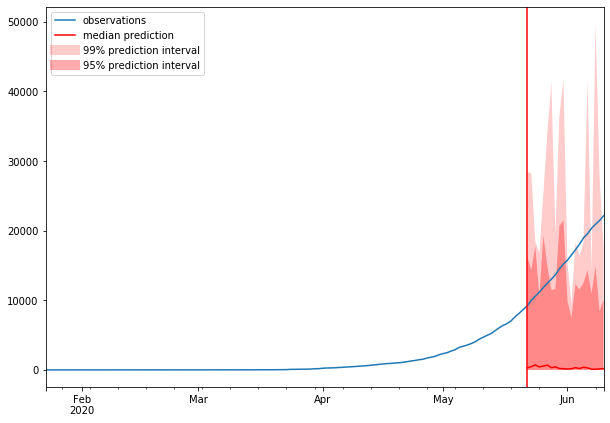

<Figure size 432x288 with 0 Axes>

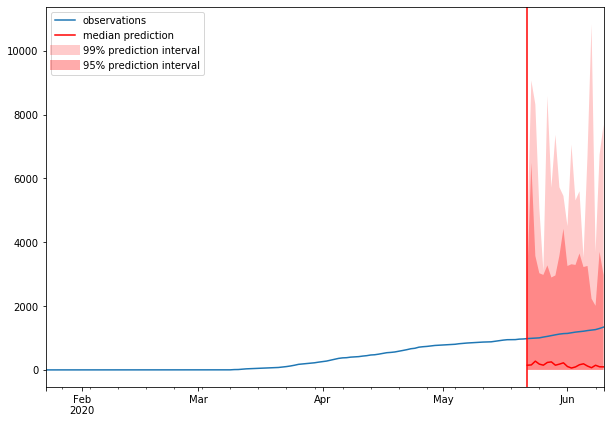

<Figure size 432x288 with 0 Axes>

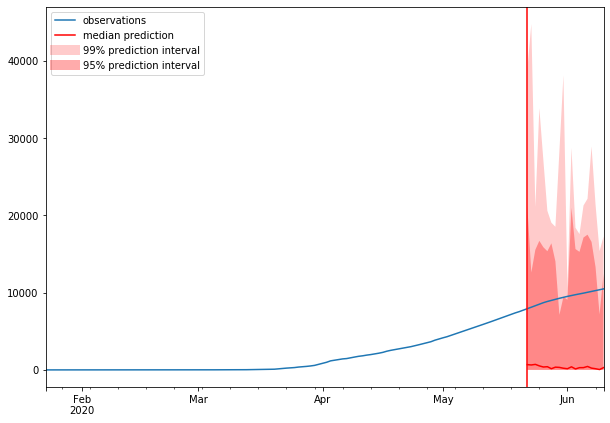

<Figure size 432x288 with 0 Axes>

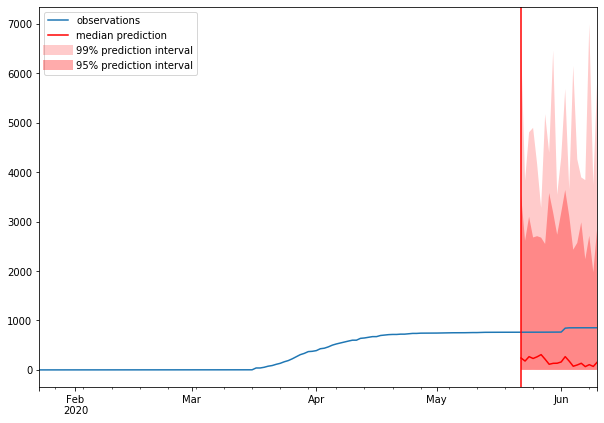

<Figure size 432x288 with 0 Axes>

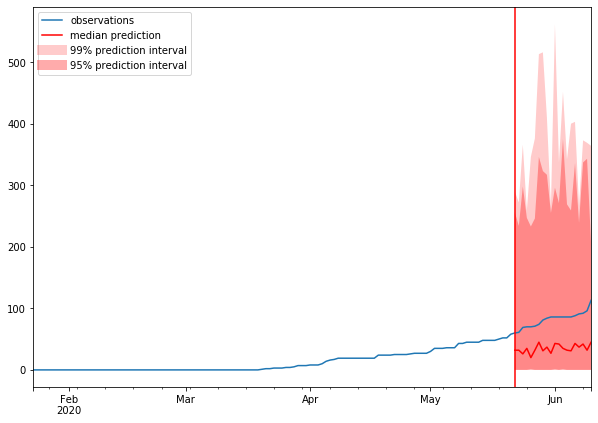

<Figure size 432x288 with 0 Axes>

In [124]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    

def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='r')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    if i == 0:
        print(ts_entry[-prediction_length:])
        print(pd.DataFrame(forecast_entry.samples).median())
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)

## Comments
The result is seemingly good but there is still much space for improvements. The main problem is that the data got from kaggle contain only a few features which limits us from creating more precise models. The current is very close to a baseline model because it contains only one extra feature. The next thing to do is to find additional data on kaggle or from the internet to improve the model.

In [89]:
len(tss)

3463

In [90]:
tss[0]

,0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
2020-01-27,0.0
...,...
2020-06-06,19551.0
2020-06-07,20342.0
2020-06-08,20917.0
2020-06-09,21459.0


In [92]:
len(forecasts)

3463

In [95]:
forecast_entry = forecasts[0]
forecast_entry.samples.shape

(100, 20)

In [99]:
pd.DataFrame(forecast_entry.samples)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,16096.0,7405.0,1317.0,11759.0,2163.0,46205.0,18507.0,9650.0,25208.0,8971.0,5573.0,22993.0,8961.0,15112.0,10810.0,10745.0,11526.0,13785.0,17650.0,17936.0
1,7363.0,25109.0,9972.0,5658.0,3691.0,26630.0,17636.0,1854.0,4668.0,3438.0,2052.0,22734.0,4116.0,465.0,7524.0,8844.0,11118.0,49957.0,8018.0,25153.0
2,717.0,27066.0,2834.0,12965.0,6130.0,2121.0,6374.0,9985.0,41516.0,12602.0,5124.0,21364.0,30469.0,2139.0,39568.0,44658.0,7136.0,25457.0,44252.0,8416.0
3,184.0,1144.0,3735.0,3793.0,158.0,3729.0,9291.0,16524.0,6183.0,6335.0,6639.0,12818.0,3632.0,8361.0,9934.0,3951.0,17238.0,26615.0,18657.0,11307.0
4,2132.0,18121.0,2697.0,9913.0,30676.0,28168.0,5884.0,3725.0,4032.0,8766.0,3795.0,18875.0,53357.0,5397.0,34092.0,17755.0,18201.0,24403.0,21533.0,47187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,84.0,16717.0,1074.0,15867.0,26529.0,17985.0,6884.0,6401.0,24558.0,19095.0,10330.0,68089.0,13377.0,20251.0,30998.0,28907.0,45358.0,7632.0,6252.0,8975.0
96,800.0,2394.0,23541.0,18129.0,54781.0,25543.0,3829.0,17457.0,14731.0,27542.0,4499.0,48369.0,9376.0,15169.0,5338.0,16429.0,19751.0,32504.0,18754.0,13682.0
97,18713.0,5842.0,4910.0,43543.0,39429.0,2880.0,6762.0,10662.0,35318.0,32979.0,15977.0,43552.0,18334.0,11980.0,2343.0,10783.0,4523.0,15691.0,15971.0,34391.0
98,6652.0,1164.0,51095.0,2019.0,4055.0,10025.0,588.0,12468.0,13677.0,16969.0,16009.0,20510.0,4409.0,10954.0,23744.0,10967.0,15034.0,24857.0,33397.0,15082.0


In [115]:
pd.DataFrame(forecast_entry.samples).median(axis=0)

0      6465.0
1      6355.0
2     10184.5
3     10158.5
4      9337.0
5     10997.0
6     10414.5
7     10068.0
8     12354.0
9     10773.0
10    12630.5
11    16411.5
12    10563.5
13    12051.5
14    12489.0
15    12512.0
16    15138.0
17    15386.5
18    16408.5
19    19595.0
dtype: float32

In [104]:
tss[0][-20:]

,0
2020-05-22,9216.0
2020-05-23,9998.0
2020-05-24,10582.0
2020-05-25,11173.0
2020-05-26,11831.0
2020-05-27,12456.0
2020-05-28,13036.0
2020-05-29,13659.0
2020-05-30,14525.0
2020-05-31,15205.0
